# Homework #1: Simple Linear Regreesion

## Background
The New York Times has published data for case counts and deaths for each county and state across the US. They also have a few additional datasets, one of which is a July 2020 survey of how regularly people in each county wore masks. This data comes for an online survey of about 250,000 responses.

You've been tasked with looking at the relationship between reported mask usage and case counts per capita (at the county level) for the state of Utah. This analysis is with real data so expect some level of cleaning and manipulation.

Data and descriptions are available at their GitHub page (https://github.com/nytimes/covid-19-data) but for consistency I've uploaded the relevant ones to the Canvas page under "Datasets".

Relevant Datasets:
* `county_census.csv`: Population estimates in 2019 by county
* `mask-use-by-county.csv`: Reported mask usage taken from the NY Time July 2020 survey
* `us-counties.csv`: Case and death county by county


### Task 1
First, you'll need to read in the three datasets and `merge` them together. The `SimpleLinearRegression.ipynb` file may be a useful reference.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from sklearn.datasets import load_diabetes
from math import sqrt

import os
os.getcwd()

census = pd.read_csv('county_census.csv')
mask = pd.read_csv('mask-use-by-county.csv')
counties = pd.read_csv('us-counties.csv')
df = census.merge(mask, left_on='FIPS', right_on='COUNTYFP')
df = df.merge(counties, left_on='FIPS', right_on='fips')
df.head()

,Unnamed: 0,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2019,FIPS,...,date,county,state,fips,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths
0,2,50,3,6,1,1,Alabama,Autauga County,55869,1001,...,2022-05-05,Autauga,Alabama,1001.0,15840,216.0,12691.0,194.0,3149.0,22.0
1,3,50,3,6,1,3,Alabama,Baldwin County,223234,1003,...,2022-05-05,Baldwin,Alabama,1003.0,55713,680.0,38977.0,473.0,16736.0,207.0
2,4,50,3,6,1,5,Alabama,Barbour County,24686,1005,...,2022-05-05,Barbour,Alabama,1005.0,5671,98.0,3238.0,68.0,2433.0,30.0
3,5,50,3,6,1,7,Alabama,Bibb County,22394,1007,...,2022-05-05,Bibb,Alabama,1007.0,6444,104.0,4126.0,72.0,2318.0,32.0
4,6,50,3,6,1,9,Alabama,Blount County,57826,1009,...,2022-05-05,Blount,Alabama,1009.0,14985,243.0,11068.0,202.0,3917.0,41.0


### Task 2
Since we're only interested in Utah, create a new data frame that contains only the merged data for the state of Utah. If you need to do some Googling, I'd suggest searching "conditional subset pandas dataframe".

In [26]:
df = df[df['STNAME'].isin(['Utah'])]
df.head()

,Unnamed: 0,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2019,FIPS,...,date,county,state,fips,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths
2768,2823,50,4,8,49,1,Utah,Beaver County,6710,49001,...,2022-05-05,Beaver,Utah,49001.0,1609,16.0,NaN,NaN,NaN,NaN
2769,2824,50,4,8,49,3,Utah,Box Elder County,56046,49003,...,2022-05-05,Box Elder,Utah,49003.0,14100,124.0,NaN,NaN,NaN,NaN
2770,2825,50,4,8,49,5,Utah,Cache County,128289,49005,...,2022-05-05,Cache,Utah,49005.0,37192,109.0,NaN,NaN,NaN,NaN
2771,2826,50,4,8,49,7,Utah,Carbon County,20463,49007,...,2022-05-05,Carbon,Utah,49007.0,5234,46.0,NaN,NaN,NaN,NaN
2772,2827,50,4,8,49,9,Utah,Daggett County,950,49009,...,2022-05-05,Daggett,Utah,49009.0,151,0.0,NaN,NaN,NaN,NaN


### Task 3
The case count data is just an absolute cumulative count, meaning that larger counties unsurprisingly have much larger case counts. This may skew our results since we're just interested in the relative relationship between reported mask usage and cases. Create a new variable that is a ratio of `cases/population`. Note: the name of the population variable is `POPESTIMATE2019`.

In [39]:
df['cases_per_capita'] = df['cases']/df['POPESTIMATE2019']
df = df.drop(['confirmed_cases','confirmed_deaths','probable_cases','probable_deaths','Cases/Population','fips','COUNTY','DIVISION','REGION','SUMLEV','Unnamed: 0','STATE','state'], axis = 1)

df

,STNAME,CTYNAME,POPESTIMATE2019,FIPS,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,date,county,cases,deaths,cases_per_capita
2768,Utah,Beaver County,6710,49001,49001,0.099,0.026,0.271,0.283,0.320,2022-05-05,Beaver,1609,16.0,0.239791
2769,Utah,Box Elder County,56046,49003,49003,0.084,0.116,0.111,0.270,0.419,2022-05-05,Box Elder,14100,124.0,0.251579
2770,Utah,Cache County,128289,49005,49005,0.090,0.108,0.080,0.310,0.411,2022-05-05,Cache,37192,109.0,0.289908
2771,Utah,Carbon County,20463,49007,49007,0.107,0.134,0.114,0.293,0.353,2022-05-05,Carbon,5234,46.0,0.255779
2772,Utah,Daggett County,950,49009,49009,0.091,0.296,0.102,0.330,0.181,2022-05-05,Daggett,151,0.0,0.158947
2773,Utah,Davis County,355481,49011,49011,0.035,0.055,0.077,0.314,0.518,2022-05-05,Davis,100743,403.0,0.283399
2774,Utah,Duchesne County,19938,49013,49013,0.051,0.259,0.033,0.469,0.188,2022-05-05,Duchesne,4371,27.0,0.219230
2775,Utah,Emery County,10012,49015,49015,0.122,0.109,0.106,0.239,0.424,2022-05-05,Emery,2472,28.0,0.246904
2776,Utah,Garfield County,5051,49017,49017,0.062,0.056,0.232,0.264,0.386,2022-05-05,Garfield,929,16.0,0.183924
2777,Utah,Grand County,9754,49019,49019,0.056,0.111,0.098,0.176,0.558,2022-05-05,Grand,2322,6.0,0.238056


### Task 4
Finally, run a regression where our **predictor variable** is the proportion of people that responed "Always" to the question of "*How often do you wear a mask in public when you expect to be within six feet of another person?*" and the **response variable** is your newly created `cases_per_capita` variable.

In [45]:
df['ALWAYS_NORM'] = (df['ALWAYS'] - df['ALWAYS'].mean())/df['ALWAYS'].std()
df['cases_per_capita_norm'] = (df['cases_per_capita'] - df['cases_per_capita'].mean())/df['cases_per_capita'].std()

results = smf.ols('cases_per_capita_norm ~ ALWAYS_NORM', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     cases_per_capita_norm   R-squared:                       0.284
Model:                               OLS   Adj. R-squared:                  0.258
Method:                    Least Squares   F-statistic:                     10.72
Date:                   Thu, 19 May 2022   Prob (F-statistic):            0.00290
Time:                           13:20:33   Log-Likelihood:                -35.791
No. Observations:                     29   AIC:                             75.58
Df Residuals:                         27   BIC:                             78.32
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -8.882e-16      0.160  -5.55e-15      1.000      -0.328       0.328
ALWAYS_NORM     0.5331      0.163      3.275      0.003       0.199       0.867
==============================================================================
Omnibus:                        7.740   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                6.245
Skew:                          -1.098   Prob(JB):                       0.0440
Kurtosis:                       3.585   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

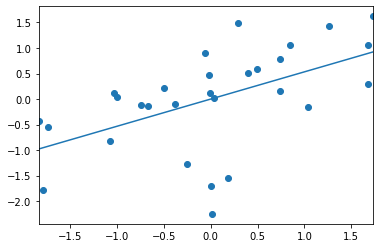

In [46]:
fig = sm.graphics.abline_plot(model_results=results)
ax = fig.axes[0]
ax.scatter(df['ALWAYS_NORM'], df['cases_per_capita_norm'])
plt.show()

### Questions

1. Are the coefficient estimate significant? What evidence is there to support your answer?

2. What proportion of variance in the response is explained by this model?

3. How would you interpret the estimates of the coefficient?

4. Does your model make sense intuitively? What could explain this result?



In [ ]:
# 1. The correlation estimate is significant, as there is only a .003 chance that the coefficient is due to chance.

# 2. .284

# 3. For each standard deviation increase in people that always wear masks in public, there is a .5331
# standard deviation increase in cases.

# 4. The number of people always wearing masks in public is not the only variable that goes into the spread of covid, but
# it is a variable. It makes sense that there is a correlation, but that the r-squared value is low enough to leave room for
# the other variables that affect the spread of covid.